<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from geometry import find_max_dist_brute, find_max_dist
import seaborn as sns
from tqdm import tqdm

In [11]:
sns.set_theme()

In [12]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [13]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [14]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

In [15]:
g1 = G1()
g2 = G2()

In [136]:
class MCMCSolver: 
    def __init__(self, dataset,lmbd,beta = 0.1,eps=0.05):
        self.dataset = dataset
        self.state = np.random.binomial(1, 0, dataset.N).astype(bool) #randomly initialize state
        self.lmbd = lmbd
        self.beta = beta
        self.eps = eps
               
    #code from solvers 
    def dist(self,pt1: np.ndarray, pt2: np.ndarray) -> np.float:
        return np.linalg.norm(pt1 - pt2, ord=2)
    
    def objective(self):
        #to use the functions from geometry.py
        mask = self.dataset.x[self.state]
        #return (self.state*self.dataset.v).sum() - self.lmbd*self.dataset.N*np.pi*(find_max_dist_brute(mask)/2)**2
        return (self.state*self.dataset.v).sum() - self.lmbd*self.dataset.N*np.pi*(self.radius(self.state)/2)**2
        
    #compute the radius of the state
    #direct computation, probably more clever way to compute radius difference
    def radius(self,state):
        best = 0
        for k,i in enumerate(state):
            if i > 0:
                for l,j in enumerate(state):
                    if j > 0:
                        best = np.maximum(best,self.dist(self.dataset.x[k],self.dataset.x[l]))
        return best
    
    def compute_diff(self,state_1,state_2,i):
        diff_1 = (int(state_2[i]) - int(state_1[i]))*self.dataset.v[i]
#         diff_2 = self.lmbd*self.dataset.N*np.pi*((self.radius(state_2)/2)**2-(self.radius(state_1)/2)**2)

        #to use the functions from geometry.py
        mask_1 = self.dataset.x[state_1]
        mask_2 = self.dataset.x[state_2]
        diff_2 = self.lmbd*self.dataset.N*np.pi*((find_max_dist_brute(mask_2)/2)**2-(find_max_dist_brute(mask_1)/2)**2)
        return diff_1-diff_2

    def acceptance_proba(self,diff,beta):
        proba = np.exp(beta*diff)
        return np.minimum(1.0,proba)
    
    #check overleaf for math writing
    def update_beta(self,objectives):
        #optim later
        values = sorted(list(set(objectives)))
        f0 = values[-1]
        if len(values) < 2:
            self.beta = self.beta*(1+self.eps)
            return 
        f1 = values[-2]
        
        N0 = objectives.count(f0)
        N1 = objectives.count(f1)
        update_b = (1/(f0-f1))*np.log(N1/(N0*self.eps))

        if self.beta < abs(update_b):
            self.beta = abs(update_b)
    
    def solve(self,n_it,verbose=True,schedule1=True):
        if verbose: 
            print("Initial state:",self.state)
        n_states = []
        objectives = []
        betas = []
        for it in range(n_it):
            #print("Iteration",it)
            next_state = self.state.copy()
            
            #flip one state at random
            i = np.random.choice(self.dataset.N)
            next_state[i] = True^next_state[i]
                        
            #update state with acceptance probability
            diff = self.compute_diff(self.state, next_state,i)
            if np.random.uniform() < self.acceptance_proba(diff, self.beta):
                self.state = next_state
            #print(self.state.sum())
            #print()
            
            #record number of states and objective for plotting, as per project description
            if (it % 1) == 0:
                n_states.append(self.state.sum())
                objectives.append(self.objective())
                
#             #beta scheduling    
            if schedule1:
                if ((it % 500) == 0) and (it > 0):
                    self.beta = self.beta*5
            else:
                if ((it % 100) == 0) and (it > 0):
                    self.update_beta(objectives)
                    betas.append(self.beta)
        
        if verbose: 
            print("Final state:",self.state)
            print(betas)
        return n_states,objectives

In [139]:
np.random.seed(10)
g1.refresh()

mcmc = MCMCSolver(dataset = g1, lmbd = 0,beta = 1)
n_states, objectives = mcmc.solve(n_it = 1000,verbose=False)

In [140]:
np.random.seed(10)
mcmc = MCMCSolver(dataset = g1, lmbd = 0,beta = 1)
n_states2, objectives2 = mcmc.solve(n_it = 1000,verbose=False,schedule1=False)

In [143]:
max(objectives2)

51.5418776128885

In [144]:
max(objectives)

50.34750793909152

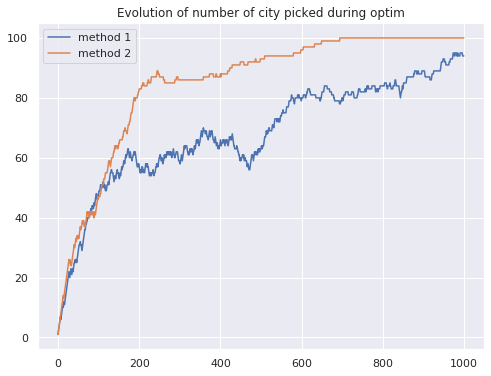

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.title('Evolution of number of city picked during optim')
plt.plot(n_states,label='method 1')
plt.plot(n_states2,label='method 2')
plt.legend()
plt.show()

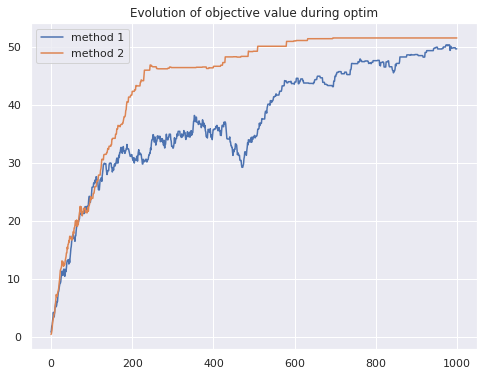

In [142]:
plt.figure(figsize=(8,6))
plt.title('Evolution of objective value during optim')
plt.plot(objectives,label='method 1')
plt.plot(objectives2,label='method 2')
plt.legend()
plt.show()

In [128]:
def vary_lmbd(g,lmbds,schedule=True,avg_it=10,n_it=100):
    objs = []
    nb_cities = []
    
    for lmbd in tqdm(lmbds):
        avg_obj = []
        avg_city = []
        
        for _ in range(avg_it):
            mcmc = MCMCSolver(dataset = g, lmbd = lmbd ,beta = 1)
            n_states, objectives = mcmc.solve(n_it = n_it,verbose=False, schedule1=schedule)
            avg_obj.append(objectives[-1])
            avg_city.append(n_states[-1])
            g.refresh()
            
        objs.append(np.mean(avg_obj))
        nb_cities.append(np.mean(avg_city))
    return objs, nb_cities

In [129]:
np.random.seed(10)

bins = 30
lambds = np.linspace(0,1,bins)

In [134]:
objs1, nb_cities1 = vary_lmbd(g1,lambds,avg_it=5,n_it=500)
#objs2, nb_cities2 = vary_lmbd(g2,lambds,avg_it=10,n_it=500)

100%|██████████| 30/30 [19:33<00:00, 39.11s/it]


In [137]:
objs2, nb_cities2 = vary_lmbd(g1,lambds,schedule=False,avg_it=5,n_it=500)

100%|██████████| 30/30 [26:26<00:00, 52.88s/it]  


No handles with labels found to put in legend.


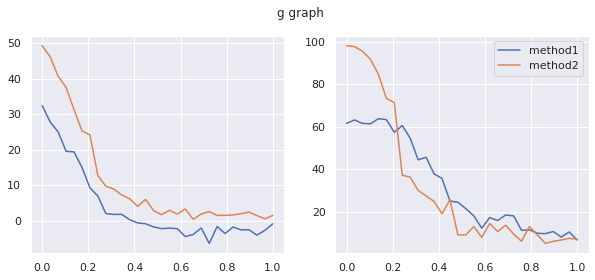

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
fig.suptitle('g graph')

#E[objective] vs lambda
ax1.plot(lambds,objs1,label='method1')
ax1.plot(lambds,objs2,label='method2')
plt.legend()

#E[|S|] vs lambda
ax2.plot(lambds,nb_cities1,label='method1')
ax2.plot(lambds,nb_cities2,label='method2')
plt.legend()

plt.show()